In [1]:
import numpy as np
import os
import h5py
from datetime import datetime, timedelta, time
import pytz
import scipy.io
import matplotlib.pyplot as plt 
import pickle

%matplotlib inline

In [2]:
data_dir = '/lustre/storeB/project/IT/geout/machine-ocean/data_raw/coare_ocean_sites/mat'

# Open one file to see how it looks like

In [3]:
filepath = data_dir + '/ASO_SFC_BUOY-TAO-8N95W-19970208_19970324.despikedStress.mat'
f = scipy.io.loadmat(filepath)
f

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Sep 26 11:45:05 2023',
 '__version__': '1.0',
 '__globals__': [],
 'Latitude': array([[8, 8, 8, ..., 8, 8, 8]], dtype=uint8),
 'Longitude': array([[-95, -95, -95, ..., -95, -95, -95]], dtype=int16),
 'Time': array([[8.553906e+08, 8.553942e+08, 8.553978e+08, ..., 8.592390e+08,
         8.592426e+08, 8.592462e+08]]),
 'WindDirection': array([[68.04123777, 56.14898785, 60.39839711, ..., 29.58539165,
         38.76551774, 24.994566  ]]),
 'WindStress': array([[0.03006626, 0.02060551, 0.02080073, ..., 0.01700417, 0.0154259 ,
         0.01306821]]),
 'Notes': array([[array(['Time Units: seconds since 01-JAN-1970 00:00:00 UTC'], dtype='<U50')],
        [array(['WindDirection Units: met direction -- degrees-clockwise North, coming FROM'],
               dtype='<U74')                                                                  ],
        [array(['WindStress Units: N m-2'], dtype='<U23')]], dtype=object)}

# The location of the Coriolis buoy varies 

For the collocation, we have decided to take the average of all locations.

In [4]:
filepath = data_dir + '/ASO_SFC_BUOY-Coriolis-61010-20110103_20110223.despikedStress.mat'
f = scipy.io.loadmat(filepath)
f


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Sep 26 11:22:21 2023',
 '__version__': '1.0',
 '__globals__': [],
 'Latitude': array([[43.84120178, 43.84117126, 43.84117126, 43.84117126, 43.84120178,
         43.84120178, 43.84117126, 43.84120178, 43.84370041, 43.84370041,
         43.84366989, 43.84370041, 43.84366989, 43.84370041, 43.84366989,
         43.84370041, 43.82699966, 43.82699966, 43.82699966, 43.82699966,
         43.82699966, 43.82699966, 43.82699966, 43.82699966, 43.82733154,
         43.82730103, 43.82730103, 43.84880066, 43.84883118, 43.84883118,
         43.84883118, 43.84880066, 43.84880066, 43.84883118, 43.84880066,
         43.84949875, 43.84949875, 43.84949875, 43.84949875, 43.84949875,
         43.84949875, 43.84949875, 43.84949875, 43.85020065, 43.85017014,
         43.85017014, 43.85017014, 43.85020065, 43.85020065, 43.85017014,
         43.85020065, 43.84817123, 43.84817123, 43.84817123, 43.84820175,
         43.84820175, 43.84817123, 

In [5]:
np.mean(f['Latitude'])

43.83585768860656

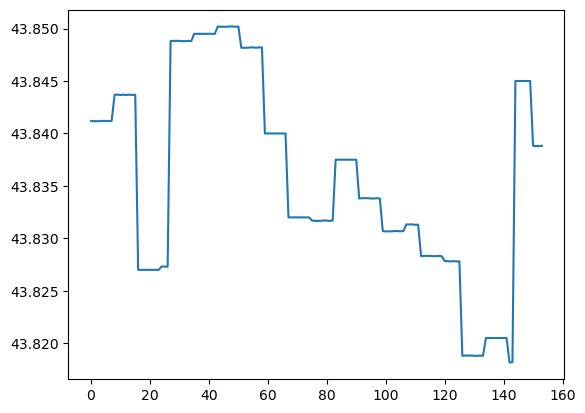

In [6]:
plt.plot(f['Latitude'][0, :])

# Get time stamps and location of Ocean Site buoys

The files contain stress data computed with the COARE 3.5 algorithm on in situ measurements.

https://dods.ndbc.noaa.gov/oceansites/

In [7]:
metadata_dict = {}
postfix_mapping = {}
date_format = '%Y%m%d'

# iterate over files in data_dir
for filename in os.listdir(data_dir):
    # Open MAT file
    filepath = os.path.join(data_dir, filename)
    try:
        f = scipy.io.loadmat(filepath)
    except:
        print(filename)
        pass

    # Get the buoy name from the file name and us it to define the dictionary key
    # Since there are multiple files with data from the same buoy, we use a postfix
    buoy_name = filename.split('-')[1] + '_' + filename.split('-')[2]
    if buoy_name in postfix_mapping.keys():
        postfix_mapping[buoy_name] = postfix_mapping[buoy_name] + 1
    else:
        postfix_mapping[buoy_name] = 1
        
    dict_key = buoy_name + '_' + str(postfix_mapping[buoy_name])
    
    # Define the start and the end of each MAT file based on the file name
    # Alternatively, take the first and last elements of the time variable in the file
    # date = datetime.fromtimestamp(f['Time'][-1, -1])
    
    datetime_start_str = filename.split('-')[-1].split('_')[0]
    datetime_start_obj = datetime.strptime(datetime_start_str, date_format)
    datetime_start_obj = pytz.utc.localize(datetime_start_obj)
    
    datetime_end_str = filename.split('-')[-1].split('.')[0].split('_')[-1]
    datetime_end_obj = datetime.strptime(datetime_end_str, date_format)
    datetime_end_obj = pytz.utc.localize(datetime_end_obj)
    # Add 23 hours and 59 minutes to the end of the period
    datetime_end_obj = datetime.combine(datetime_end_obj.date(), time(23, 59))
    
    # Fill in dictionary
    metadata_dict[dict_key] = {
        'datetime_start' : datetime_start_obj,
        'datetime_end': datetime_end_obj,
        'lat':np.nanmean(f['Latitude']),
        'lon':np.nanmean(f['Longitude']),
        'file_name' : filename
    }

In [8]:
 filename

'ASO_SFC_BUOY-NDBC-51002-20161017_20180705.despikedStress.mat'

In [9]:
metadata_dict

{'TAO_2N137E_1': {'datetime_start': datetime.datetime(2010, 4, 20, 0, 0, tzinfo=<UTC>),
  'datetime_end': datetime.datetime(2011, 5, 3, 23, 59),
  'lat': 2.0,
  'lon': 137.0,
  'file_name': 'ASO_PROF_BUOY-TAO-2N137E-20100420_20110503.despikedStress.mat'},
 'TAO_8S125W_1': {'datetime_start': datetime.datetime(2017, 2, 4, 0, 0, tzinfo=<UTC>),
  'datetime_end': datetime.datetime(2019, 6, 15, 23, 59),
  'lat': -8.0,
  'lon': -125.0,
  'file_name': 'ASO_PROF_BUOY-TAO-8S125W-20170204_20190615.despikedStress.mat'},
 'TAO_8N95W_1': {'datetime_start': datetime.datetime(2015, 4, 14, 0, 0, tzinfo=<UTC>),
  'datetime_end': datetime.datetime(2015, 6, 6, 23, 59),
  'lat': 8.0,
  'lon': -95.0,
  'file_name': 'ASO_PROF_BUOY-TAO-8N95W-20150414_20150606.despikedStress.mat'},
 'OceanSITES_WHOTS_1': {'datetime_start': datetime.datetime(2015, 7, 12, 0, 0, tzinfo=<UTC>),
  'datetime_end': datetime.datetime(2016, 7, 25, 23, 59),
  'lat': 22.699999999999992,
  'lon': -158.0,
  'file_name': 'ASO_PROF_BUOY-Ocea

with open(data_dir + '/ocean_sites_metadata_dict.pickle', 'wb') as handle:
    pickle.dump(metadata_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)